In [1]:
from triangulate import Triangulate as tr

import pandas as pd, numpy as np, matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [620]:
from pykalman import KalmanFilter

kalman_transition = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

kalman_observation = [[1, 0, 0, 0], [0, 0, 1, 0]]

def kalman_smooth(XY, n = 0, depth = 0, kalman_cov = 0, return_current = False):

    if not n: n = len(XY)
    if not depth: depth = n

    if n > len(XY):   return np.nan
    if n - depth < 0: return np.nan
    
    measurements = XY[n-depth:n,:]
    measurements = np.ma.array(measurements, mask = np.isnan(measurements))

    initial_state_mean = [measurements[0, 0], 0, measurements[0, 1], 0]

    kf = KalmanFilter(transition_matrices    = kalman_transition,
                      observation_matrices   = kalman_observation,
                      initial_state_mean     = initial_state_mean,
                      observation_covariance = np.eye(2) * kalman_cov)

    means, covariances = kf.smooth(measurements)

    if return_current: return np.array([means[-1,0], means[-1,2]])
    
    return np.array([means[:,0], means[:,2]])


In [51]:
tracks = {"P" : pd.read_csv("triangulate/P.csv"),
          "V" : pd.read_csv("triangulate/V.csv")}

In [52]:
for k in "PV":
    obs = tracks[k].groupby("o").count().ts
    obs = list(obs[obs > 100].index)
    
    # tracks[k] = tracks[k][tracks[k].o.isin(obs)].dropna().copy()
    tracks[k] = tracks[k][tracks[k].o.isin(obs)].copy()


o
0    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

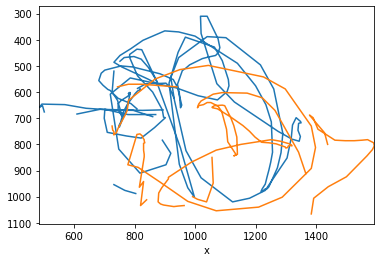

In [53]:
fig, ax = plt.subplots()
ax.invert_yaxis()

tracks["P"].groupby("o").plot("x", "y", ax = ax, legend = False)

o
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

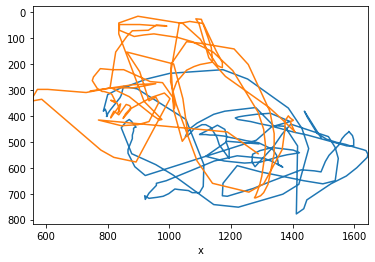

In [46]:
fig, ax = plt.subplots()
ax.invert_yaxis()

tracks["V"].groupby("o").plot("x", "y", ax = ax, legend = False)

In [670]:
def add_kalman(df, x = "x", y = "y"):

    XYs = kalman_smooth(df[[x, y]].values, kalman_cov = 15)

    df["xs".format(cam)] = XYs[0]
    df["ys".format(cam)] = XYs[1]
    
    df.dropna(inplace = True)


In [671]:
p1 = tracks["P"].loc[tracks["P"].o == 0, ["x", "y", "ts"]]
v1 = tracks["V"].loc[tracks["V"].o == 2, ["x", "y", "ts"]]

p2 = tracks["P"].loc[tracks["P"].o == 2, ["x", "y", "ts"]]
v2 = tracks["V"].loc[tracks["V"].o == 1, ["x", "y", "ts"]]

for df in [p1, v1, p2, v2]: add_kalman(df)

pv1 = pd.merge_asof(p1, v1, on = "ts", suffixes = ("_P", "_V")).dropna()
pv2 = pd.merge_asof(p2, v2, on = "ts", suffixes = ("_P", "_V")).dropna()

pv1_X = pd.merge_asof(p1, v2, on = "ts", suffixes = ("_P", "_V")).dropna()
pv2_X = pd.merge_asof(p2, v1, on = "ts", suffixes = ("_P", "_V")).dropna()

In [672]:
pv2[["x_P", "x_V", "y_P", "y_V"]].corr()

,x_P,x_V,y_P,y_V
x_P,1.000000,0.987654,0.021456,0.292607
x_V,0.987654,1.000000,-0.017095,0.242060
y_P,0.021456,-0.017095,1.000000,0.850836
y_V,0.292607,0.242060,0.850836,1.000000


In [673]:
pv2[["xs_P", "xs_V", "ys_P", "ys_V"]].corr()

,xs_P,xs_V,ys_P,ys_V
xs_P,1.000000,0.990599,0.010179,0.311412
xs_V,0.990599,1.000000,-0.012871,0.269735
ys_P,0.010179,-0.012871,1.000000,0.855130
ys_V,0.311412,0.269735,0.855130,1.000000


In [674]:
pv1_X[["x_P", "x_V", "y_P", "y_V"]].corr()

,x_P,x_V,y_P,y_V
x_P,1.000000,-0.770283,0.305508,-0.244620
x_V,-0.770283,1.000000,-0.209153,0.215875
y_P,0.305508,-0.209153,1.000000,-0.405582
y_V,-0.244620,0.215875,-0.405582,1.000000


In [675]:
pv2_X[["x_P", "x_V", "y_P", "y_V"]].corr()

,x_P,x_V,y_P,y_V
x_P,1.000000,-0.818193,0.021456,-0.408625
x_V,-0.818193,1.000000,0.077972,0.364901
y_P,0.021456,0.077972,1.000000,-0.329147
y_V,-0.408625,0.364901,-0.329147,1.000000


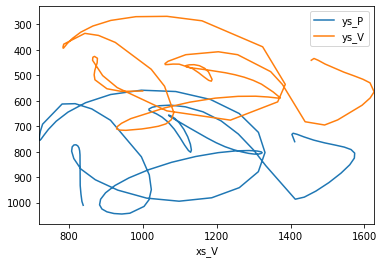

In [676]:
fig, ax = plt.subplots()
ax.invert_yaxis()

pv2.plot("xs_P", "ys_P", ax = ax)
pv2.plot("xs_V", "ys_V", ax = ax)

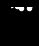

In [677]:
pv = pv1.copy()

t = tr("P", "V", calib = "calib")
for ri, row in pv.iterrows():
    
    t.triangulate(row[["xs_P", "ys_P"]].values.reshape(1, 2), 
                  row[["xs_V", "ys_V"]].values.reshape(1, 2),
                  max_reproj_error = np.inf)
    
pts = np.array(t.detections).reshape(-1, 3).T


pv["idx"]  = pv.index
pv["x_tr"] = pts[0]
pv["y_tr"] = pts[1]
pv["z_tr"] = pts[2]
pv["err_tr"] = t.error

13.86929280937325

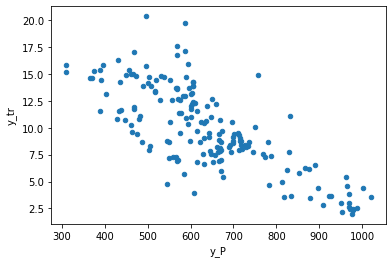

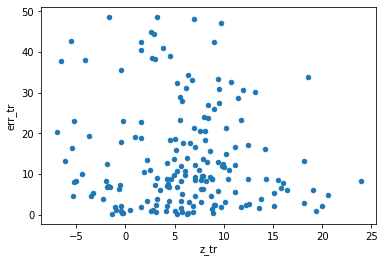

In [678]:
pv_acc = pv[pv.err_tr < 50]

pv_acc.plot.scatter("y_P", "y_tr")
pv_acc.plot.scatter("z_tr", "err_tr")

pv_acc.err_tr.mean()

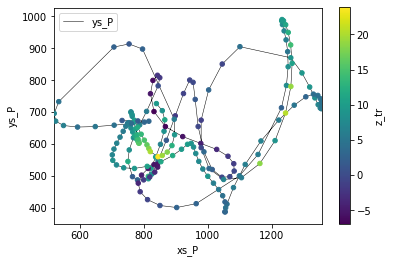

In [679]:
fig, ax = plt.subplots()

pv_acc.plot("xs_P", "ys_P", c = "k", ax = ax, lw = 0.5)
pv_acc.plot.scatter("xs_P", "ys_P", c = "z_tr", cmap = "viridis", zorder = 10, ax = ax)

ax.set_aspect("equal")

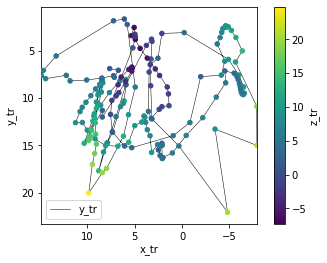

In [647]:
fig, ax = plt.subplots()

pv_acc.plot("x_tr", "y_tr", c = "k", lw = 0.5, ax = ax)
pv_acc.plot.scatter("x_tr", "y_tr", c = "z_tr", cmap = "viridis", zorder = 10, ax = ax)

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_aspect("equal")

In [648]:
def plot_3d(pts, elev = 90, azim = 0):

    fig, ax = plt.subplots(figsize = (10, 10), 
                           subplot_kw = {'projection': '3d'})

    ax.set_xlim(np.quantile(pts[0], 0.05), np.quantile(pts[0], 0.95))
    ax.set_ylim(np.quantile(pts[1], 0.05), np.quantile(pts[1], 0.95))
    ax.set_zlim(np.quantile(pts[2], 0.05), np.quantile(pts[2], 0.95))

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.plot(xs = pts[0], ys = pts[1], zs = pts[2], lw = 0.5, color = "k")
    ax.scatter(xs = pts[0], ys = pts[1], zs = pts[2], s = 10, 
               c = pts[2], cmap = "viridis", zorder = 20)

    ax.set_xlim(12, -18)
    ax.set_ylim(-2, 22)

    
    ax.view_init(elev = elev, azim = azim)
    plt.show()
    

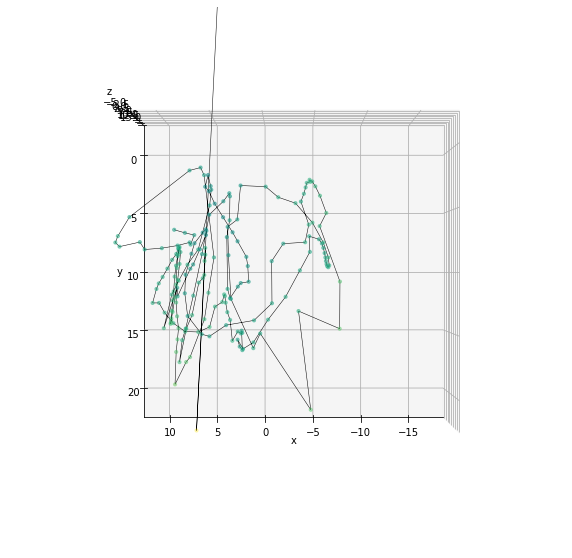

In [649]:
plot_3d(pts, -90, -90)

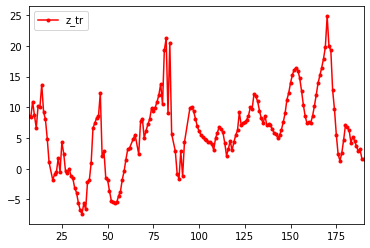

In [650]:
ax = pv_acc.plot(y = "z_tr", style = "r.-")

### Simulated Data

In [681]:
import cv2

def get_intrinsics(cam):

    K    = np.load('./calib/{}/K.npy'.format(cam))
    dist = np.load('./calib/{}/dist.npy'.format(cam))

    return K, dist

def get_extrinsics(cam):

    r = np.load('./calib/{}/rvec.npy'.format(cam))
    t = np.load('./calib/{}/tvec.npy'.format(cam))

    return r, t


In [796]:
def simulate_detection(x, y, z, kalman_cov = 0, noise_scale = 0):
    
    df = pd.DataFrame({"x" : x, "y" : y, "z" : z})

    for cam in "PV":

        K, dist    = get_intrinsics(cam)
        rvec, tvec = get_extrinsics(cam)

        axis_proj, _ = cv2.projectPoints(df[["x", "y", "z"]].values.reshape(-1,3),
                                         rvec, tvec, K, dist)

        # Independent noise...
        for xi, x in enumerate("xy"):
            df[x + cam] = axis_proj[:,0,xi]
            df[x + cam] += np.random.normal(scale = noise_scale, 
                                            size = len(df[x + cam]))
            
            df[x + cam] = df[x + cam].astype(int)

        XYs = kalman_smooth(df[["x" + cam, "y" + cam]].values, 
                            kalman_cov = kalman_cov)

        df["x{}s".format(cam)] = XYs[0]
        df["y{}s".format(cam)] = XYs[1]


    t = tr("P", "V", calib = "calib")

    for ri, row in df.iterrows():

        t.triangulate(row[["xPs", "yPs"]].values.reshape(1, 2), 
                      row[["xVs", "yVs"]].values.reshape(1, 2), 
                      max_reproj_error = np.inf)

    pts = np.array(t.detections).reshape(-1, 3).T

    df["x_tr"] = pts[0]
    df["y_tr"] = pts[1]
    df["z_tr"] = pts[2]
    df["err_tr"] = t.error
    
    return df

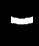

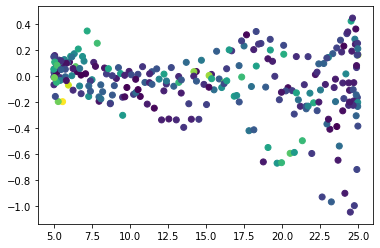

In [802]:
θ = np.arange(0, 8*np.pi, 0.1)

scale = 10
xctr, yctr, zctr = 0, 10, 15

x = xctr + scale * np.sin(θ)
y = yctr + scale * np.cos(θ)
z = zctr + scale * np.cos(θ)

noise_scale = 0.3 

df = simulate_detection(x, y, z, kalman_cov = 5, 
                        noise_scale = noise_scale * scale)

fig, ax = plt.subplots()
ax.scatter(df["z"], df["z"] - df["z_tr"],
           c = df["err_tr"], cmap = "viridis")

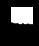

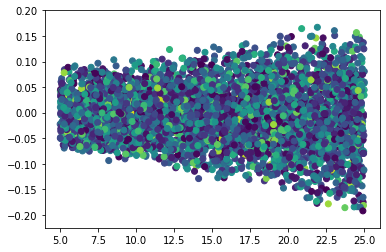

In [954]:
N = 5000

scale = 10
z_scale = 10
noise_scale = 0.0

xctr, yctr, zctr = 0, 10, 15

x = xctr + scale * 2 * (np.random.rand(N) - 0.5)
y = yctr + scale * 2 * (np.random.rand(N) - 0.5)
z = zctr + z_scale * 2 * (np.random.rand(N) - 0.5)

df = simulate_detection(x, y, z, kalman_cov = 0,
                        noise_scale = noise_scale * scale)

fig, ax = plt.subplots()
ax.scatter(df["z"], df["z"] - df["z_tr"],
           c = df["err_tr"], cmap = "viridis")

In [955]:
import statsmodels.formula.api as smf

# xV_params = smf.ols("xP ~ xV + yV", data = df).fit().params.to_dict()
# yV_params = smf.ols("yP ~ xV + yV", data = df).fit().params.to_dict()

In [957]:
xV_params, yV_params

({'Intercept': -0.8686565182530579,
  'xV': 0.9435469630558109,
  'yV': 0.015327682351882324},
 {'Intercept': 309.49741885638474,
  'xV': -0.030894471342262066,
  'yV': 0.903576749298806})

In [971]:
np.cos(0.4)

0.9210609940028851

In [972]:
np.arccos((0.9035 + 0.9435) / 2)

0.39368966363062663

In [1006]:
df['xV_lin'] = xV_params["xV"] * df.xV + xV_params["yV"] * df.yV + xV_params["Intercept"]
df['yV_lin'] = yV_params["xV"] * df.xV + yV_params["yV"] * df.yV + yV_params["Intercept"]

5.7935225592415565

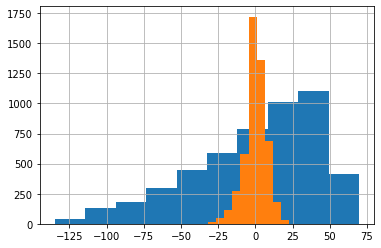

In [1007]:
(df["yV_lin"] - df["yP"]).hist()
(df["xV_lin"] - df["xP"]).hist()


(df["yV_lin"] - df["yP"]).std() / (df["xV_lin"] - df["xP"]).std()

In [1008]:
matches = []

xy_scale = 5.5

SN, N = 10, 100
for n in range(N):

    S = df.sample(SN)

    S["idx"] = S.index
    S["all"] = 1

    S2 = pd.merge(S[["xP", "yP", "idx", "all"]],
                  S[["xV_lin", "yV_lin", "idx", "all"]], 
                  on = "all", suffixes = ("_P", "_V"))

    S2["match"] = S2["idx_P"] == S2["idx_V"]

    S2["d_xP_abs"] = np.abs(S2["xV_lin"] - S2["xP"])
    S2["d_yP"] = S2["yV_lin"] - S2["yP"]

    S2["dtot2"] = (xy_scale * S2["d_xP_abs"]) ** 2 + S2["d_yP"] ** 2

    S2["keep_x"] = S2["d_xP_abs"] < 20
    S2["keep_y"] = (S2["d_yP"] > -150) & (S2["d_yP"] < 75)

    S2 = S2[S2.keep_x & S2.keep_y]\
           .sort_values(by = ["idx_P", "dtot2"])\
           .drop_duplicates("idx_P", keep = "first")

    matches.append(S2["match"].astype(int).sum())

print(xy_scale, sum(matches) / SN / N)

5.5 0.943


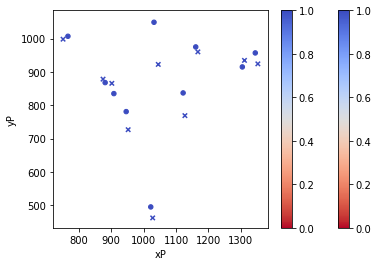

In [1009]:
fig, ax = plt.subplots()

S2.plot(x = "xV_lin", y = "yV_lin", kind = "scatter", vmin = 0, vmax = 1,
        marker = "x", c = S2["match"], cmap = "coolwarm_r", ax = ax)

S2.plot(x = "xP", y = "yP", kind = "scatter", vmin = 0, vmax = 1,
        marker = "o", c = S2["match"], cmap = "coolwarm_r", ax = ax)

In [963]:
rvecP, _ = get_extrinsics("P")
rvecV, _ = get_extrinsics("V")

In [1011]:
cv2.Rodrigues(rvecP)[0]

array([[-0.98761582,  0.15679826,  0.00541205],
       [-0.13905193, -0.89077159,  0.43265522],
       [ 0.07266049,  0.42654458,  0.90154322]])

In [1012]:
cv2.Rodrigues(rvecV)[0]

array([[-0.98280007,  0.17917432, -0.04472787],
       [-0.1787732 , -0.862347  ,  0.47370643],
       [ 0.04630508,  0.47355486,  0.87954626]])

In [964]:
np.matmul(cv2.Rodrigues(rvecP)[0].T, cv2.Rodrigues(rvecV)[0])

array([[ 0.99885221, -0.02263565,  0.04221242],
       [ 0.02489593,  0.99824069, -0.05381179],
       [-0.04092009,  0.05480095,  0.99765846]])

In [993]:
np.arccos(0.5 * (0.99885221 + 0.99824069)) / np.pi

0.01716456227311547

In [995]:
np.arcsin(0.5 * (0.02263565 + 0.02489593)) / np.pi

0.007565598215059326